In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectrum as spectrum
import darkhistory.spec.spectra as spectra
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tfl
import matplotlib
import matplotlib.pyplot as plt
import pickle

matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

In [3]:
transfer_func_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw","rb"))

In [4]:
eng = transfer_func_table.in_eng
tf_rs_arr = transfer_func_table.rs

In [5]:
#Initialize
eng_ind = 499
mwimp = eng[eng_ind]
print(mwimp)

rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1]), 
                           -transfer_func_table[0].dlnz*10)
                )

# Initial injection is 2 photons, to match up with what we have in file.
photon_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                        np.array([mwimp]), 
                                        eng)
                                       
photon_spec_init.rs = rs_list[0]

5.39725754969e+12


In [6]:
transfer_func_table.coarsen(10, delete_tfs=False)

In [7]:
transfer_func_table.at_val('rs',rs_list)

In [8]:
transfer_func_table.rs.size

101

In [9]:
photon_spectra = spectools.evolve(photon_spec_init, transfer_func_table, save_steps=True)
fin_phot_spec = spectools.evolve(photon_spec_init, transfer_func_table, end_rs=13)

In [10]:
file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [11]:
# file_spectra = spectrum.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
#                    for photspec,rs in zip(file_photonspectrum, file_rs)], 
#                 rebin_eng = eng)

file_spectra = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

file_spectra_orig = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

4.19539378033
4.19539378033
13.1180245519


[0.0001, 10000000000000.0, 1e-22, 1000.0]

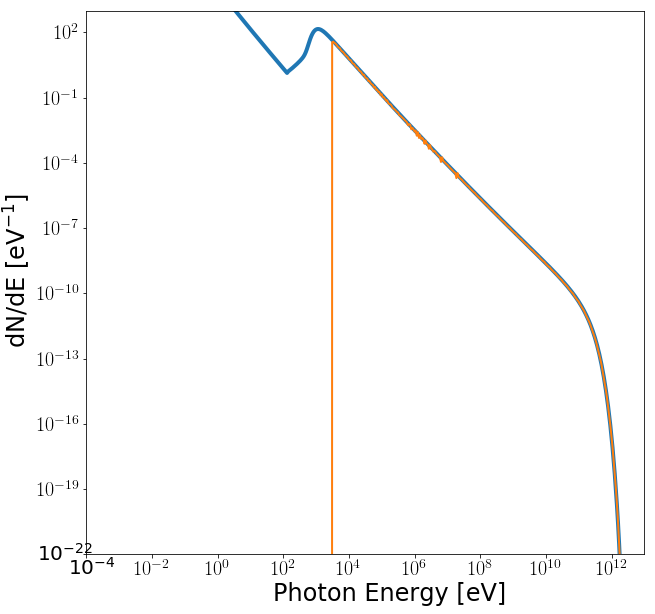

In [12]:
i=100
j=2*10*i
print(photon_spectra[i].rs)
print(file_spectra[j].rs)
print(fin_phot_spec.rs)

spec_to_plot = photon_spectra[i]
spec_to_plot.rebin(file_spectra.eng)
fin_phot_spec.rebin(file_spectra.eng)

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
plt.plot(file_spectra.eng, file_spectra[j].dNdE, linewidth=4)
plt.plot(spec_to_plot.eng, spec_to_plot.dNdE, linewidth=2)
# plt.plot(fin_phot_spec.eng, fin_phot_spec.dNdE, linewidth=2)
# plt.plot(photon_spectra.eng, photon_spectra[i].dNdE, linewidth=2)
# plt.plot(file_spectra[j].eng, file_spectra[j].dNdE)

# plt.plot(photon_spectra.eng, photon_spectra[i].totN('bin',np.arange(501)))
# plt.plot(file_spectra[j].eng, file_spectra[j].totN('bin',np.arange(501)))
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)
plt.ylabel('dN/dE [eV$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-22, 1e3])
# b = file_spectra.plot(2)
# axb = b.add_subplot(1,1,1)
# axb.set_xscale('log')
# axb.set_yscale('log')


In [13]:
np.set_printoptions(threshold=np.nan)
print(eng[eng_ind])
utils.compare_arr([photon_spectra[i].eng,
                   photon_spectra[i].dNdE,
#                    file_spectra[j].eng,
                   file_spectra[j].dNdE,
                   file_spectra[j+1].dNdE
                   ])

5.39725754969e+12
[[  1.03931913e-04   0.00000000e+00   1.36864848e+08   1.36885200e+08]
 [  1.12265617e-04   0.00000000e+00   1.46853504e+08   1.46874384e+08]
 [  1.21267552e-04   0.00000000e+00   1.57490736e+08   1.57511648e+08]
 [  1.30991301e-04   0.00000000e+00   1.68805760e+08   1.68826960e+08]
 [  1.41494741e-04   0.00000000e+00   1.80827600e+08   1.80848736e+08]
 [  1.52840392e-04   0.00000000e+00   1.93583040e+08   1.93603728e+08]
 [  1.65095785e-04   0.00000000e+00   2.07097520e+08   2.07117600e+08]
 [  1.78333869e-04   0.00000000e+00   2.21394464e+08   2.21413792e+08]
 [  1.92633438e-04   0.00000000e+00   2.36493648e+08   2.36511152e+08]
 [  2.08079607e-04   0.00000000e+00   2.52410160e+08   2.52426000e+08]
 [  2.24764316e-04   0.00000000e+00   2.69156064e+08   2.69169504e+08]
 [  2.42786876e-04   0.00000000e+00   2.86736896e+08   2.86746880e+08]
 [  2.62254562e-04   0.00000000e+00   3.05148960e+08   3.05155008e+08]
 [  2.83283250e-04   0.00000000e+00   3.24383456e+08   3.24

0

In [14]:
bin_width = spectools.get_log_bin_width(file_spectra_orig[1].eng)*file_spectra_orig[1].eng

# utils.compare_arr([tf_at_rs_list[eng_ind].eng,tf_at_rs_list[eng_ind][0].dNdE, 
#                    file_spectra_orig[1].eng, file_spectra_orig[1].dNdE*bin_width])

utils.compare_arr([file_spectra_orig[1].eng, file_spectra_orig[1].dNdE*bin_width, 
                   file_spectra_orig[2].dNdE*bin_width])


[[  1.03931913e-04   4.38920918e+02   3.30482329e+02]
 [  1.12265617e-04   5.11386977e+02   3.85296975e+02]
 [  1.21267552e-04   5.95778075e+02   4.49175165e+02]
 [  1.30991301e-04   6.94045818e+02   5.23607749e+02]
 [  1.41494741e-04   8.08455269e+02   6.10330504e+02]
 [  1.52840392e-04   9.41640212e+02   7.11360704e+02]
 [  1.65095785e-04   1.09665579e+03   8.29043820e+02]
 [  1.78333869e-04   1.27705112e+03   9.66107502e+02]
 [  1.92633438e-04   1.48694245e+03   1.12571819e+03]
 [  2.08079607e-04   1.73110309e+03   1.31155874e+03]
 [  2.24764316e-04   2.01506846e+03   1.52790008e+03]
 [  2.42786876e-04   2.34525398e+03   1.77970591e+03]
 [  2.62254562e-04   2.72908231e+03   2.07273035e+03]
 [  2.83283250e-04   3.17515000e+03   2.41364567e+03]
 [  3.05998107e-04   3.69340593e+03   2.81019422e+03]
 [  3.30534338e-04   4.29534142e+03   3.27133884e+03]
 [  3.57037989e-04   4.99423418e+03   3.80745546e+03]
 [  3.85666816e-04   5.80540938e+03   4.43055638e+03]
 [  4.16591224e-04   6.74656

0

In [15]:
utils.compare_arr([file_eng,file_photonspectrum[1],file_photonspectrum[2],
                   file_photonspectrum[3]])

[[  1.03931913e-04   5.47526080e+07   4.12255800e+07   4.13336880e+07]
 [  1.12265617e-04   5.90568600e+07   4.44955200e+07   4.46121560e+07]
 [  1.21267552e-04   6.36952960e+07   4.80218160e+07   4.81476920e+07]
 [  1.30991301e-04   6.86931040e+07   5.18240160e+07   5.19598560e+07]
 [  1.41494741e-04   7.40769600e+07   5.59232280e+07   5.60697480e+07]
 [  1.52840392e-04   7.98756320e+07   6.03419280e+07   6.05000080e+07]
 [  1.65095785e-04   8.61195600e+07   6.51041920e+07   6.52746600e+07]
 [  1.78333869e-04   9.28414480e+07   7.02358880e+07   7.04196960e+07]
 [  1.92633438e-04   1.00076000e+08   7.57644480e+07   7.59626720e+07]
 [  2.08079607e-04   1.07860112e+08   8.17194960e+07   8.19331760e+07]
 [  2.24764316e-04   1.16233120e+08   8.81322880e+07   8.83626800e+07]
 [  2.42786876e-04   1.25236848e+08   9.50365120e+07   9.52847840e+07]
 [  2.62254562e-04   1.34915248e+08   1.02467752e+08   1.02735224e+08]
 [  2.83283250e-04   1.45315120e+08   1.10463824e+08   1.10752056e+08]
 [  3.

0

In [16]:
a_fig=tf_at_rs_list[eng_ind].plot((2,400),step=100)
a = a_fig.get_axes()[0]
a.set_xscale('log')
a.set_yscale('log')
plt.axis([1e3, 2e11, 1e-20, 1e3])

NameError: name 'tf_at_rs_list' is not defined

In [ ]:
np.set_printoptions(threshold=np.nan)
print(eng[eng_ind])
utils.compare_arr([photon_spectra[i].eng,
                   photon_spectra[i].totN('eng', spectools.get_bin_bound(photon_spectra[i].eng)),
                   file_spectra[j].totN('eng', spectools.get_bin_bound(photon_spectra[i].eng)) 
                   ])

In [ ]:
tf_rs_31 = spectra.Spectra([transfer_func[0] for transfer_func in tf_at_rs_list])

In [ ]:
a_fig = tf_rs_31.plot((106, 399),step=50)
a = a_fig.get_axes()[0]
a.set_xscale('log')
a.set_yscale('log')
plt.axis([1e3, 2e11, 1e-20, 1e3])

In [ ]:
a = np.array([1,2,3,4,5])
a[np.where(a < 5)][-1]

In [ ]:
a[[1,2,3,1,1,1,1.]]

In [ ]:
b = [1,2,3,4]
b[[1,2]]